# 3. Categorical Mixture Model + Gibbs Sampling Algorithm

In [1]:
# Common imports 
from ast import literal_eval

import gensim
import numpy as np
import pandas as pd

import math
from typing import Tuple, Dict, List

import scipy.special

import sys
print(sys.version)

/Users/mac/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


3.8.3 (default, Jul  2 2020, 11:26:31) 
[Clang 10.0.0 ]


## 1. Hyperparameters


In [2]:
K = 5 # Number of mixture components
I = 120 # Number of words in the dictionary
N = None # Number of documents

## 2. Load and preprocess the data

First, we need to load the data from the csv. This file contains the documents already processed and cleaned after applying the following steps:

1. Tokenization
2. Homogeneization, which includes:
    1. Removing capitalization.
    2. Removing non alphanumeric tokens (e.g. punktuation signs)
    3. Stemming/Lemmatization.
3. Cleaning
4. Vectorization


We load it as a `pandas` dataframe.


In [3]:
df = pd.read_csv('../../apmla_2021_tutorials-main/L3/old/data/tweets_cleaned.csv')
df.drop_duplicates(subset="tweet", inplace=True)

df['tokens'] = df['tokens'].apply(literal_eval) #Transform the string into a list of tokens
X_tokens = list(df['tokens'].values)


In [4]:
print('Columns: {}\n'.format(' | '.join(df.columns.values)))

print('Tweet:\n{}'.format(df.loc[1, 'tweet']))
print('Tweet cleaned:\n{}'.format(df.loc[1, 'tweets_clean']))
print('Tweet tokens:\n{}'.format(X_tokens[1]))

Columns: tweet_id | timestamp | user_id | tweet | tweets_clean | tokens

Tweet:
OSINT people - please retweet, if possible. My friend is looking for women involved in OSINT. https://twitter.com/manisha_bot/status/1181594280336531457 …
Tweet cleaned:
osint people   please retweet  if possible  my friend is looking for women involved in osint
Tweet tokens:
['osint', 'peopl', 'retweet', 'possibl', 'friend', 'look', 'woman', 'involv', 'osint']


### Create the dictionary

Up to this point, we have transformed the raw text collection in a list of documents stored in `X_tokens`, where each document is a collection 
of the words that are most relevant for semantic analysis. Now, we need to convert these data (a list of token lists) into 
a numerical representation (a list of vectors, or a matrix). To do so, we will start using the tools provided by the `gensim` library. 

As a first step, we create a dictionary containing all tokens in our text corpus, and assigning an integer identifier to each one of them.



In [5]:
dictionary = gensim.corpora.Dictionary(X_tokens)

dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=I)

I = len(dictionary)

### Create Bag of Words (BoW): Numerical version of documents
In the second step, let us create a numerical version of our corpus using the `doc2bow` method. In general, 
`D.doc2bow(token_list)` transforms any list of tokens into a list of tuples `(token_id, n)`, one per each token in 
`token_list`, where `token_id` is the token identifier (according to dictionary `D`) and `n` is the number of occurrences 
of such token in `token_list`. 

*Exercise:* Apply the `doc2bow` method from gensim dictionary `D`, to all tokens in every document in `X_tokens`. 
The result must be a new list named `X_bow` where each element is a list of tuples `(token_id, number_of_occurrences)`.

In [6]:
X_bow = list()
keep_tweet = list()
for tweet in X_tokens:
    tweet_bow = dictionary.doc2bow(tweet)
    if len(tweet_bow) > 1:
        X_bow.append(tweet_bow)
        keep_tweet.append(True)
    else:
        keep_tweet.append(False)

df_data = df[keep_tweet]

N = len(df_data)


Finally, we transform the BoW representation `X_bow` into a matrix, namely `X_matrix`, in which the i-th row and j-th column represents the 
number of occurrences of the j-th word of the dictionary in the i-th document. This will be the matrix used in the algorithm.

In [7]:
X_matrix = np.zeros([N, I])
for i, doc_bow in enumerate(X_bow):
    word_list = list()
    for word in doc_bow:
        X_matrix[i, word[0]] = word[1]

        
print('N: {} I: {}'.format(N, I))

N: 5568 I: 120


### Exercise 1: Analytical forms of different Gibbs sampling algorithms

1. Algorithm 1

--- YOUR ANSWER GOES HERE ----

2. Algorithm 2 

--- YOUR ANSWER GOES HERE ---

2. Algorithm 3

--- YOUR ANSWER GOES HERE ---

## Exercise 2
Implement the three algorithms in the boxes below

In [8]:
def compute_lset(ns):
    return scipy.special.logsumexp(ns)

### Exercise 2.1: Implement the log likelihood of X

We provide you with the method to initialize the parameters

In [9]:
def initialize_parameters(N, K, alpha_v, gamma_v) -> Tuple[np.array, np.array, np.array]:
    pi_vector = np.random.dirichlet(alpha_v, size=1).flatten()  # [, K]
    Z_matrix = np.random.multinomial(n=1, pvals=pi_vector, size=N)  # One hot encoding Nx K
    theta_matrix = np.random.dirichlet(gamma_v, size=K)  # [K, I]
    return pi_vector, theta_matrix, Z_matrix

In [10]:
def log_likelihood_X(X, Z, theta_matrix):
    ## BEGIN SOLUTION
    log_lik = np.sum(Z * (X_matrix @ np.log(theta_matrix).T))
    ## END SOLUTION
    return log_lik


In [11]:
np.random.seed(1234)

alpha_v=1*np.ones(K)
gamma_v=np.ones(I)

pi_vector, theta_matrix, Z_matrix =  initialize_parameters(N, K, alpha_v, gamma_v)

log_lik = log_likelihood_X(X_matrix, Z_matrix, theta_matrix)
print(f'log_lik: {log_lik.sum()}')
assert math.isclose(log_lik,-120602.80 , rel_tol=1e-2)

log_lik: -120602.80671488505


### Exercise 2.2: Implement the posterior distributions needeed for Algorithm 1

In [12]:
def pi_Z(z_matrix, alpha_v):
    ### BEGIN SOLUTION
    m_k = np.sum(z_matrix, axis=0)
    alphap_v = alpha_v + m_k

    pi_sample = np.random.dirichlet(alphap_v, size=1).flatten()  # [, K]
    ### END SOLUTION
    return pi_sample


    

def thetak_XZ(X, Z, k, gamma_v):
    ### BEGIN SOLUTION

    def gamma_p_v_k(z_matrix, x_matrix, k, gamma_v):
        z_k = (z_matrix[:, [k]].T == 1).flatten()
        c_k = np.sum(x_matrix[z_k, :], axis=0)
        gamma_pp_v = gamma_v + c_k
        return gamma_pp_v
    gammap_v = gamma_p_v_k(Z, X, k, gamma_v)
    thetak_sample = np.random.dirichlet(gammap_v, size=1).flatten()  # [, I]
    ### END SOLUTION
    return thetak_sample


def Z_pi_theta_xn(X, pi_vector, theta_matrix):
    ### BEGIN SOLUTION
    N, I = X.shape
    K = theta_matrix.shape[0]

    log_theta_matrix = np.log(theta_matrix)
    log_pi_vector = np.log(pi_vector)

    last_term = np.zeros([N, 1])
    last_term2 = X @ log_theta_matrix.T
    ns = last_term2 + np.tile(log_pi_vector, [N, 1])  # [N, K]
    for i in range(N):
        last_term[i] = compute_lset(ns[i, :])

    last_term = np.tile(last_term, [1, K])
    log_r_matrix = np.tile(log_pi_vector, [N, 1]) + last_term2 - last_term
    r_matrix = np.exp(log_r_matrix)

    Z_probs = np.clip(r_matrix, 1e-250, None)
    def f(probs):
        K = len(probs)
        a = np.zeros(K, dtype=np.int64)
        q = np.random.choice(K, size=1, replace=True, p=probs)
        a[q] = 1
        return a
    Z_sample = np.apply_along_axis(f, 1, Z_probs)
    ### END SOLUTION
    return  Z_probs, Z_sample


In [13]:
np.random.seed(1234)

alpha_v=1*np.ones(K)
gamma_v=np.ones(I)

pi_vector, theta_matrix, Z_matrix =  initialize_parameters(N, K, alpha_v, gamma_v)

pi_sample =  pi_Z(Z_matrix, alpha_v)

print(f'pi_sample: {np.around(pi_sample, 3)}')
assert math.isclose(pi_sample[2],0.114 , rel_tol=1e-2)


### BEGIN HIDDEN TESTS
def pi_Z_true(z_matrix, alpha_v):
    m_k = np.sum(z_matrix, axis=0)
    alphap_v = alpha_v + m_k

    pi_sample = np.random.dirichlet(alphap_v, size=1).flatten()  # [, K]
    return pi_sample

    
alpha_v=1*np.ones(K)
gamma_v=np.ones(I)

for seed in range(1,10):
    np.random.seed(seed)
    pi_vector, theta_matrix, Z_matrix =  initialize_parameters(N, K, alpha_v, gamma_v)
    pi_sample =  pi_Z(Z_matrix, alpha_v)

    np.random.seed(seed)
    pi_vector, theta_matrix, Z_matrix =  initialize_parameters(N, K, alpha_v, gamma_v)
    pi_sample_t =  pi_Z_true(Z_matrix, alpha_v)
    
    assert all([math.isclose(l1, l2 , rel_tol=1e-2) for l1, l2 in zip(pi_sample, pi_sample_t)])

### END HIDDEN TESTS



pi_sample: [0.04  0.209 0.114 0.322 0.316]


In [14]:
np.random.seed(1234)

alpha_v=1*np.ones(K)
gamma_v=np.ones(I)

pi_vector, theta_matrix, Z_matrix =  initialize_parameters(N, K, alpha_v, gamma_v)


thetak_sample = thetak_XZ(X_matrix, Z_matrix, 0, gamma_v)
print(f'thetak_sample: {np.around(thetak_sample, 4)}')
assert math.isclose(thetak_sample[0],0.0097 , rel_tol=1e-2)


### BEGIN HIDDEN TESTS
def thetak_XZ_true(X, Z, k, gamma_v):

    def gamma_p_v_k_true(z_matrix, x_matrix, k, gamma_v):
        z_k = (z_matrix[:, [k]].T == 1).flatten()
        c_k = np.sum(x_matrix[z_k, :], axis=0)
        gamma_pp_v = gamma_v + c_k
        return gamma_pp_v
    gammap_v = gamma_p_v_k_true(Z, X, k, gamma_v)
    thetak_sample = np.random.dirichlet(gammap_v, size=1).flatten()  # [, I]
    return thetak_sample

    
alpha_v=1*np.ones(K)
gamma_v=np.ones(I)

for seed in range(1,10):
    np.random.seed(seed)
    pi_vector, theta_matrix, Z_matrix =  initialize_parameters(N, K, alpha_v, gamma_v)
    thetak_sample = thetak_XZ(X_matrix, Z_matrix, 0, gamma_v)

    np.random.seed(seed)
    pi_vector, theta_matrix, Z_matrix =  initialize_parameters(N, K, alpha_v, gamma_v)
    thetak_sample_t = thetak_XZ(X_matrix, Z_matrix, 0, gamma_v)
    
    assert all([math.isclose(l1, l2 , rel_tol=1e-2) 
                for l1, l2 in zip(thetak_sample.flatten(), thetak_sample_t.flatten())])

### END HIDDEN TESTS


thetak_sample: [0.0097 0.0138 0.0132 0.0059 0.0252 0.0104 0.0024 0.014  0.0054 0.0072
 0.0038 0.0101 0.0084 0.0078 0.0157 0.0142 0.0076 0.0168 0.0084 0.003
 0.0119 0.0225 0.0137 0.0188 0.0108 0.0113 0.0145 0.0098 0.0048 0.0104
 0.0041 0.0038 0.0095 0.0054 0.029  0.0215 0.0104 0.0075 0.007  0.0032
 0.0042 0.0156 0.0162 0.005  0.0092 0.0021 0.0107 0.0148 0.0064 0.0049
 0.0034 0.0033 0.0016 0.0072 0.0032 0.0071 0.0091 0.0049 0.0061 0.0045
 0.009  0.0079 0.0151 0.0062 0.0027 0.0055 0.0086 0.0049 0.004  0.0182
 0.0052 0.0183 0.0096 0.0014 0.0055 0.0018 0.0087 0.002  0.0086 0.018
 0.0048 0.0013 0.0078 0.0037 0.0118 0.0112 0.0046 0.0032 0.0053 0.0089
 0.0032 0.0017 0.0173 0.0027 0.0068 0.0064 0.01   0.0094 0.0084 0.0043
 0.0062 0.0055 0.0089 0.0034 0.0026 0.0048 0.0088 0.0088 0.0054 0.0053
 0.006  0.0056 0.0047 0.0061 0.0072 0.0148 0.0071 0.0067 0.0039 0.0118]


In [15]:
np.random.seed(1234)

alpha_v=1*np.ones(K)
gamma_v=np.ones(I)

pi_vector, theta_matrix, z_vector =  initialize_parameters(N, K, alpha_v, gamma_v)

Z_probs, Z = Z_pi_theta_xn(X_matrix, pi_vector, theta_matrix)
print(f'Z_probs[10]: {Z_probs[10]}')
assert math.isclose(Z_probs[10, 2],0.63694589, rel_tol=1e-2)


### BEGIN HIDDEN TESTS
def Z_pi_theta_xn_true(X, pi_vector, theta_matrix):
    N, I = X.shape
    K = theta_matrix.shape[0]

    log_theta_matrix = np.log(theta_matrix)
    log_pi_vector = np.log(pi_vector)

    last_term = np.zeros([N, 1])
    last_term2 = X @ log_theta_matrix.T
    ns = last_term2 + np.tile(log_pi_vector, [N, 1])  # [N, K]
    for i in range(N):
        last_term[i] = compute_lset(ns[i, :])

    last_term = np.tile(last_term, [1, K])
    log_r_matrix = np.tile(log_pi_vector, [N, 1]) + last_term2 - last_term
    r_matrix = np.exp(log_r_matrix)

    Z_probs = np.clip(r_matrix, 1e-250, None)
    def f(probs):
        K = len(probs)
        a = np.zeros(K, dtype=np.int64)
        q = np.random.choice(K, size=1, replace=True, p=probs)
        a[q] = 1
        return a
    Z_sample = np.apply_along_axis(f, 1, Z_probs)
    return  Z_probs, Z_sample

    
alpha_v=1*np.ones(K)
gamma_v=np.ones(I)

for seed in range(1,10):
    np.random.seed(seed)
    pi_vector, theta_matrix, Z_matrix =  initialize_parameters(N, K, alpha_v, gamma_v)
    Z_probs, Z = Z_pi_theta_xn(X_matrix, pi_vector, theta_matrix)

    np.random.seed(seed)
    pi_vector, theta_matrix, Z_matrix =  initialize_parameters(N, K, alpha_v, gamma_v)
    Z_probs_true, Z = Z_pi_theta_xn_true(X_matrix, pi_vector, theta_matrix)
    
    assert all([math.isclose(l1, l2 , rel_tol=1e-2) 
                for l1, l2 in zip(Z_probs.flatten(), Z_probs_true.flatten())])

### END HIDDEN TESTS


Z_probs[10]: [0.06983299 0.14951237 0.63694589 0.13975915 0.00394961]


### Exercise 2.3: Implement the posterior distributions needeed for Algorithm 1

In [16]:
def fit_no_collapsed(X, K, alpha_v, gamma_v, burn_in, n_iters):
    N, I = X.shape
    # Initialize
    pi_vector, theta_matrix, Z_matrix =  initialize_parameters(N, K, alpha_v, gamma_v)
    z_map = np.zeros([N, K])

    log_x_list = []
    ### BEGIN SOLUTION
    for it in range(n_iters):
        pi_vector = pi_Z(Z_matrix, alpha_v)
        for k in range(K):
            theta_matrix[k, :] = thetak_XZ(X, Z_matrix, k, gamma_v)

        Z_probs, Z_matrix  = Z_pi_theta_xn(X, pi_vector, theta_matrix)

            # if n % 1000 == 0: print('ITER: {} SAMPLE: {}'.format(str(it), str(n)))

        log_lik_it = log_likelihood_X(X, Z_matrix, theta_matrix)
        log_x_list.append(log_lik_it)
        print('ITER: {} | log_lik: {}'.format(str(it), log_lik_it))
        if it >= burn_in: 
            z_map += Z_matrix
    Zk = np.argmax(z_map, axis=-1)
    z_map = np.zeros([N, K])
    for i in range(N):
        z_map[i, Zk[i]] = 1.
    
    ### END SOLUTION
    return pi_vector, theta_matrix, Z_matrix, z_map, log_x_list

In [17]:
np.random.seed(1234)

alpha_v=1*np.ones(K)
gamma_v=np.ones(I)

pi_vector, theta_matrix, Z_matrix, z_map, log_x_list = fit_no_collapsed(X_matrix, K, alpha_v, gamma_v, burn_in=20, n_iters=80)

ITER: 0 | log_lik: -102556.70707606588
ITER: 1 | log_lik: -101445.8881058007
ITER: 2 | log_lik: -99603.80674701346
ITER: 3 | log_lik: -98438.38578173114
ITER: 4 | log_lik: -97465.26552522031
ITER: 5 | log_lik: -96852.38884761161
ITER: 6 | log_lik: -96385.03897160769
ITER: 7 | log_lik: -95992.65377075823
ITER: 8 | log_lik: -95949.44446492166
ITER: 9 | log_lik: -95777.06373472516
ITER: 10 | log_lik: -95725.82411663365
ITER: 11 | log_lik: -95766.7723380872
ITER: 12 | log_lik: -95608.489342709
ITER: 13 | log_lik: -95651.22110707137
ITER: 14 | log_lik: -95603.81475217552
ITER: 15 | log_lik: -95557.09853408704
ITER: 16 | log_lik: -95405.4877890053
ITER: 17 | log_lik: -95477.85448011935
ITER: 18 | log_lik: -95391.24764089886
ITER: 19 | log_lik: -95516.98664773346
ITER: 20 | log_lik: -95425.567111299
ITER: 21 | log_lik: -95378.60266203317
ITER: 22 | log_lik: -95345.54597836846
ITER: 23 | log_lik: -95290.03355411024
ITER: 24 | log_lik: -95270.73769417797
ITER: 25 | log_lik: -95138.23952785716
I

#### Exercise 2.3.1, 2.3.2, 2.3.3

Text(0, 0.5, '$log p(X|\\Theta)$')

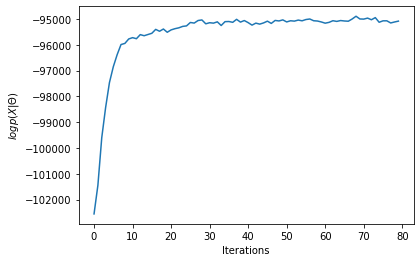

In [18]:
import matplotlib.pyplot as plt
data = plt.plot(log_x_list)
plt.xlabel('Iterations')
plt.ylabel('$log p(X|\Theta)$')

In [19]:
print(f'log_px:\n {np.around(log_x_list[-1], 4)}')

assert math.isclose(log_x_list[-1],-95130.3166, rel_tol=1e-2)

print(f'pi_vector:\n {np.around(pi_vector, 4)}')
assert math.isclose(pi_vector[0],0.0236, rel_tol=1e-2)
print(f'theta_matrix[0,:]:\n {np.around(theta_matrix[0,:], 3)}')
assert math.isclose(theta_matrix[0, -1],0.142, rel_tol=1e-2)
print(f'Z_matrix[15,:]:\n {np.around(Z_matrix[15,:], 3)}')
assert math.isclose(Z_matrix[15, 2],1, rel_tol=1e-2)

print(f'z_map[15,:]:\n {np.around(z_map[15,:], 3)}')
assert math.isclose(z_map[15, 1],1, rel_tol=1e-2)


# ### BEGIN HIDDEN TESTS
def fit_no_collapsed_true(X, K, alpha_v, gamma_v, burn_in, n_iters):
    N, I = X.shape
    # Initialize
    pi_vector, theta_matrix, Z_matrix =  initialize_parameters(N, K, alpha_v, gamma_v)
    z_map = np.zeros([N, K])

    log_x_list = []
    for it in range(n_iters):
        pi_vector = pi_Z(Z_matrix, alpha_v)
        for k in range(K):
            theta_matrix[k, :] = thetak_XZ(X, Z_matrix, k, gamma_v)

        Z_probs, Z_matrix  = Z_pi_theta_xn(X, pi_vector, theta_matrix)

            # if n % 1000 == 0: print('ITER: {} SAMPLE: {}'.format(str(it), str(n)))

        log_lik_it = log_likelihood_X(X, Z_matrix, theta_matrix)
        log_x_list.append(log_lik_it)
        print('ITER: {} | log_lik: {}'.format(str(it), log_lik_it))
        if it >= burn_in: 
            z_map += Z_matrix
    Zk = np.argmax(z_map, axis=-1)
    z_map = np.zeros([N, K])
    for i in range(N):
        z_map[i, Zk[i]] = 1.
    
    return pi_vector, theta_matrix, Z_matrix, z_map, log_x_list
    
alpha_v=1*np.ones(K)
gamma_v=np.ones(I)

for seed in range(3,5):
    np.random.seed(seed)
    pi_vector, theta_matrix, Z_matrix =  initialize_parameters(N, K, alpha_v, gamma_v)
    pi_vector_i, theta_matrix_i, Z_matrix_i, z_map_i, log_x_list_i = fit_no_collapsed(X_matrix, K, alpha_v, gamma_v, 
                                                                            burn_in=5, n_iters=10)

    np.random.seed(seed)
    pi_vector, theta_matrix, Z_matrix =  initialize_parameters(N, K, alpha_v, gamma_v)
    pi_vector_t, theta_matrix_t, Z_matrix_t, z_map_t, log_x_list_t = fit_no_collapsed_true(X_matrix, K, alpha_v, gamma_v, 
                                                                            burn_in=5, n_iters=10)
    
    assert all([math.isclose(l1, l2 , rel_tol=1e-2) 
                for l1, l2 in zip(pi_vector_i.flatten(), pi_vector_t.flatten())])
    assert all([math.isclose(l1, l2 , rel_tol=1e-2) 
                for l1, l2 in zip(theta_matrix_i.flatten(), theta_matrix_t.flatten())])
    assert all([math.isclose(l1, l2 , rel_tol=1e-2) 
                for l1, l2 in zip(z_map_i.flatten(), z_map_t.flatten())])
    assert math.isclose(log_x_list_i[-1], log_x_list_t[-1] , rel_tol=1e-2)

### END HIDDEN TESTS


log_px:
 -95085.9854
pi_vector:
 [0.0236 0.212  0.22   0.2724 0.272 ]
theta_matrix[0,:]:
 [0.001 0.001 0.002 0.    0.001 0.001 0.    0.003 0.003 0.    0.001 0.
 0.005 0.004 0.    0.    0.    0.001 0.001 0.    0.    0.    0.003 0.
 0.004 0.001 0.002 0.006 0.    0.001 0.001 0.    0.003 0.001 0.172 0.186
 0.    0.003 0.002 0.002 0.    0.001 0.    0.    0.001 0.001 0.002 0.002
 0.001 0.002 0.    0.001 0.004 0.001 0.002 0.001 0.    0.001 0.002 0.002
 0.003 0.001 0.001 0.    0.003 0.001 0.001 0.001 0.    0.    0.001 0.001
 0.001 0.    0.003 0.002 0.001 0.002 0.    0.001 0.001 0.003 0.001 0.001
 0.    0.001 0.005 0.001 0.002 0.    0.002 0.001 0.001 0.    0.001 0.
 0.004 0.152 0.    0.004 0.    0.004 0.004 0.    0.    0.001 0.003 0.
 0.    0.001 0.002 0.    0.001 0.001 0.002 0.    0.197 0.    0.    0.142]
Z_matrix[15,:]:
 [0 0 1 0 0]
z_map[15,:]:
 [0. 1. 0. 0. 0.]
ITER: 0 | log_lik: -102614.09082399111
ITER: 1 | log_lik: -101876.58422777033
ITER: 2 | log_lik: -100729.33769441972
ITER: 3 | log_

#### Exercise 2.3.4

This Github repo might be useful: https://github.com/amueller/word_cloud

### Algorithm 2

In [20]:
def Z_XZTheta(X, Z, theta_matrix, alpha_v):
    N, I = X.shape
    K = theta_matrix.shape[0]
    z_probs = np.zeros([N, K])
    z_matrix = np.zeros([N, K])
    alpha_sum =  np.sum(alpha_v)
    z_sum = np.sum(Z, axis=0)
    lik_X =np.exp(X @ np.log(theta_matrix.T))
    for n in range(N):
        z_n =  Z[n, :]
        z_sum_n = z_sum - z_n
        zn_Z = (z_sum_n + alpha_v)/(N -1 + alpha_sum)
        z_probs_n_unnormalized = zn_Z * lik_X[n,:]
        z_probs_n = (z_probs_n_unnormalized / np.sum(z_probs_n_unnormalized)).flatten()

        z_n = np.random.multinomial(n=1, pvals=z_probs_n, size=1).flatten()

        z_probs[n, :] = z_probs_n
        z_matrix[n, :] = z_n
        z_sum = z_sum_n + z_n
    return z_probs, z_matrix


In [21]:
np.random.seed(1234)

alpha_v=1*np.ones(K)
gamma_v=np.ones(I)

pi_vector, theta_matrix, z_matrix =  initialize_parameters(N, K, alpha_v, gamma_v)


z_probs, Z =  Z_XZTheta(X_matrix, z_matrix, theta_matrix, alpha_v)

print(f'z_probs[10,:]:\n {np.around(z_probs[10,:], 3)}')
print(f'Z[10,:]:\n {np.around(Z[10,:], 3)}')
assert math.isclose(z_probs[10, -2],0.147, rel_tol=1e-2)
assert math.isclose(Z[10,2],1, rel_tol=1e-2)

z_probs[10,:]:
 [0.076 0.164 0.609 0.147 0.004]
Z[10,:]:
 [0. 0. 1. 0. 0.]


In [22]:
def fit_collapsed_pi(X, K, alpha_v, gamma_v, burn_in, n_iters):
    N, I = X.shape
    # Initialize
    pi_vector, theta_matrix, z_vector =  initialize_parameters(N, K, alpha_v, gamma_v)
    z_map = np.zeros([N, K])
    log_x_list = []

    for it in range(n_iters):
        for k in range(K):
            theta_matrix[k, :] = thetak_XZ(X, z_vector, k, gamma_v)

        z_probs, z_vector = Z_XZTheta(X, z_vector, theta_matrix, alpha_v)


        log_lik_it = log_likelihood_X(X, z_vector, theta_matrix)
        log_x_list.append(log_lik_it)
        print('ITER: {} | log_lik: {}'.format(str(it), log_lik_it))
        if it > burn_in: z_map += z_vector
    Zk = np.argmax(z_map, axis=-1)
    z_map = np.zeros([N, K])
    for i in range(N):
        z_map[i, Zk[i]] = 1.
    return pi_vector, theta_matrix, z_vector, z_map, log_x_list

In [23]:
np.random.seed(1234)

alpha_v=1.0*np.ones(K)
gamma_v=np.ones(I)

pi_vector, theta_matrix, z_vector, z_map, log_x_list = fit_collapsed_pi(X_matrix, K, alpha_v, gamma_v, 
                                                                        burn_in=20, n_iters=50)

ITER: 0 | log_lik: -102559.13775768132
ITER: 1 | log_lik: -101444.95518619668
ITER: 2 | log_lik: -99857.75052971399
ITER: 3 | log_lik: -98802.7255716796
ITER: 4 | log_lik: -97944.53712724333
ITER: 5 | log_lik: -97136.46440211793
ITER: 6 | log_lik: -96737.0270584693
ITER: 7 | log_lik: -96247.9295260658
ITER: 8 | log_lik: -95853.8223348138
ITER: 9 | log_lik: -95773.4511644731
ITER: 10 | log_lik: -95622.5144382543
ITER: 11 | log_lik: -95472.80112218104
ITER: 12 | log_lik: -95522.3921689912
ITER: 13 | log_lik: -95294.66412646817
ITER: 14 | log_lik: -95383.29082012144
ITER: 15 | log_lik: -95404.78467482804
ITER: 16 | log_lik: -95281.21739551745
ITER: 17 | log_lik: -95251.20506977575
ITER: 18 | log_lik: -95339.14271425702
ITER: 19 | log_lik: -95243.88874342805
ITER: 20 | log_lik: -95248.85468193541
ITER: 21 | log_lik: -95205.2077663973
ITER: 22 | log_lik: -95225.40937871636
ITER: 23 | log_lik: -95246.82557421472
ITER: 24 | log_lik: -95251.81580697169
ITER: 25 | log_lik: -95125.19286723336
IT

Text(0, 0.5, '$log p(X|\\Theta)$')

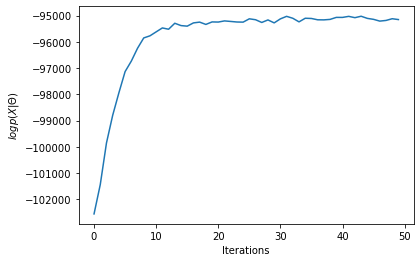

In [24]:
import matplotlib.pyplot as plt
data = plt.plot(log_x_list)
plt.xlabel('Iterations')
plt.ylabel('$log p(X|\Theta)$')

### Algorithm 3

In [25]:
def beta_function(param_v):
    denominator = scipy.special.gamma(np.sum(param_v))
    print(denominator)
    numerator = np.prod([scipy.special.gamma(p) for p in param_v])
    return numerator / denominator


def ratio_beta_function(gamma_v, count_v):
    gamma_v = [int(g) for g in gamma_v.flatten()]
    count_v = [int(g) for g in count_v.flatten()]
    gamma_sum = np.sum(gamma_v)
    Wn = np.sum(count_v)
    num_terms = list()
    for gamma_m, count_m in zip(gamma_v, count_v):
        num_terms.append(np.prod([i for i in range(gamma_m, gamma_m + count_m)]))

    num = np.prod(num_terms)

    den = np.prod([j for j in range(gamma_sum, gamma_sum + Wn)])

    return num / den


def log_ratio_beta_function(gamma_v, count_v):
    gamma_v = gamma_v.flatten()
    gamma_sum = np.sum(gamma_v)
    Wn = int(np.sum(count_v))
    num_terms = list()
    for gamma_m, count_m in zip(gamma_v, count_v):
        if count_m == 0: continue
        term_m = list(map(lambda x: np.log(x + gamma_m), list(range(count_m))))

        num_terms.append(np.sum(term_m))
    num = np.sum(num_terms)

    den = np.sum([np.log(gamma_sum + j) for j in range(0, Wn)])

    out = num - den
    return out


In [26]:
def zn_Z_function(z_matrix, n, alpha_v):
    N = z_matrix.shape[0]
    z_matrix_n = np.delete(z_matrix, n, axis=0)

    count = np.sum(z_matrix_n, axis=0)

    numerator = count + alpha_v
    denominator = N - 1 + np.sum(alpha_v)
    return numerator / denominator


def gamma_pp_v_k(z_matrix_n, x_matrix_n, k, gamma_v):
    z_k = (z_matrix_n[:, [k]].T == 1).flatten()
    gamma_pp_v = gamma_v + np.sum(x_matrix_n[z_k, :], axis=0)  # [1, N-1] * [N-1, I]
    return gamma_pp_v
    
def predictive_likelihood(z_matrix, X, n, gamma_v):
    N, K = z_matrix.shape
    z_matrix_n = np.delete(z_matrix, n, axis=0)
    count_nm = X[n, :]  # [1, I]
    x_matrix_n = np.delete(X, n, axis=0)
    predictive_lik = np.zeros(K)
    for k in range(K):
        gamma_pp_v = gamma_pp_v_k(z_matrix_n, x_matrix_n, k, gamma_v)

        predictive_lik[k] = np.exp(log_ratio_beta_function(gamma_pp_v, count_nm))

    return predictive_lik

In [27]:
def fit_collapsed_pi_theta(X, K, alpha_v, gamma_v, burn_in, n_iters):
    N, I = X.shape
    X = X.astype(int)
    pi_vector, theta_matrix, z_vector =  initialize_parameters(N, K, alpha_v, gamma_v)
    z_map = np.zeros([N, K])
    z_probs = np.zeros([N, K])
    log_x_list = []
    for it in range(n_iters):
        
        for n in range(N):
            zn_Z = zn_Z_function(z_vector, n, alpha_v)
            pred_lik = predictive_likelihood(z_vector, X, n, gamma_v)
            z_probs[n, :] = zn_Z * pred_lik / np.sum(zn_Z * pred_lik)

            z_vector[n, :] = np.random.multinomial(n=1, pvals=z_probs[n, :], size=1)

        for k in range(K):
            theta_matrix[k,:] = thetak_XZ(X, z_vector, k, gamma_v)
        log_lik_it = log_likelihood_X(X, z_vector, theta_matrix)
        log_x_list.append(log_lik_it)

        print('ITER: {} | log_lik: {}'.format(str(it), log_lik_it))

        if it > burn_in: z_map += z_vector
    Zk = np.argmax(z_map, axis=-1)
    z_map = np.zeros([N, K])
    for i in range(N):
        z_map[i, Zk[i]] = 1.
    return pi_vector, theta_matrix, z_vector, z_map, log_x_list

In [28]:
np.random.seed(1234)

alpha_v=1*np.ones(K)
gamma_v=np.ones(I)

pi_vector, theta_matrix, z_vector, z_map, log_x_list = fit_collapsed_pi_theta(X_matrix, K, alpha_v, gamma_v, 
                                                                              burn_in=3, n_iters=10)

ITER: 0 | log_lik: -101250.93189820576
ITER: 1 | log_lik: -98993.18803052124
ITER: 2 | log_lik: -97736.05883526342
ITER: 3 | log_lik: -96814.40911466136
ITER: 4 | log_lik: -96141.63683382876
ITER: 5 | log_lik: -95662.1387578638
ITER: 6 | log_lik: -95580.91738674493
ITER: 7 | log_lik: -95321.23685230789
ITER: 8 | log_lik: -95213.2863706032
ITER: 9 | log_lik: -94981.55894822773


Text(0, 0.5, '$log p(X|\\Theta)$')

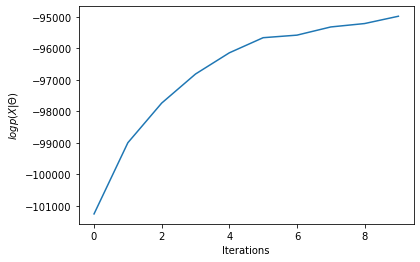

In [29]:
import matplotlib.pyplot as plt
data = plt.plot(log_x_list)
plt.xlabel('Iterations')
plt.ylabel('$log p(X|\Theta)$')

### Exercise 2.4
Explain the differences in the convergence speed of the algorithms in terms of number of iterations and time. What is the reason behind the differences?

YOUR ANSWER GOES HERE

 Below you can add the code you consider necessary to answer Exercise 2.4.